In [1]:
import pandas as pd
import tensorflow as tf

import re

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import math
import numpy
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np


import datetime

from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers, optimizers

from os import listdir
import h5py
from IPython.display import clear_output
import gc
import pprint
from tqdm import tqdm

pd.set_option('expand_frame_repr', False)
np.set_printoptions(threshold='nan')


Using TensorFlow backend.


In [2]:
def quickplot(df):
    values = df.values
    groups = [i for i in range(0, df.shape[1])]
    i = 1
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(df.columns[group], y=0.1, loc='right')
        i += 1
    plt.show()

In [3]:
df2014 = pd.read_csv('/home/yuryivz/2014_hourly.tsv', sep="\t")
df2015 = pd.read_csv('/home/yuryivz/2015_hourly.tsv', sep="\t")
df2016 = pd.read_csv('/home/yuryivz/2016_hourly.tsv', sep="\t")
df2017 = pd.read_csv('/home/yuryivz/2017_hourly.tsv', sep="\t")
df2018 = pd.read_csv('/home/yuryivz/notebooks/2018_hourly_until_0215.tsv', sep="\t")
df = pd.concat([df2014, df2015,df2016, df2017, df2018], axis=0)
df['DateTime'] = df['DateTime'].apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M'))
df = df.set_index('DateTime')[['GoldsteinScale', 'AvgTone', 'QuadClass_1', 'QuadClass_2', 'QuadClass_3', 'RootEvent_TF_1']]
print(df.head())

goldHourly = pd.read_csv('/home/yuryivz/notebooks/XAUUSD_Candlestick_1_Hour_BID.csv', sep=",")
goldHourly = goldHourly.set_index(goldHourly['Local time'].apply(lambda lt: datetime.datetime.strptime(lt[:16], '%d.%m.%Y %H:%M'))).drop('Local time', 1)
goldHourly = goldHourly.drop(['High', 'Low'], 1)
print(goldHourly.head())

vix = pd.read_csv('/home/yuryivz/notebooks/vixcurrent.csv')[['Date', 'VIX Close']]
vix['Date'] = vix['Date'].apply(lambda dt: datetime.datetime.strptime(dt, '%m/%d/%Y'))
vix = vix.set_index('Date')[df.index[0]:].resample('H').ffill().fillna(0)
print(vix.head())


                     GoldsteinScale   AvgTone  QuadClass_1  QuadClass_2  QuadClass_3  RootEvent_TF_1
DateTime                                                                                            
2014-01-01 00:00:00        0.042294  0.025808     0.608312     0.115838     0.108639        0.658704
2014-01-01 01:00:00        0.064748  0.024903     0.666558     0.068063     0.120746        0.640707
2014-01-01 02:00:00        0.082678  0.024925     0.657283     0.075614     0.121768        0.662520
2014-01-01 03:00:00        0.015036  0.026813     0.587369     0.121728     0.091950        0.665249
2014-01-01 04:00:00        0.127323  0.025942     0.636780     0.145288     0.115838        0.635471
                         Open     Close  Volume
Local time                                     
2013-05-05 00:00:00  1469.687  1469.687     0.0
2013-05-05 01:00:00  1469.687  1469.687     0.0
2013-05-05 02:00:00  1469.687  1469.687     0.0
2013-05-05 03:00:00  1469.687  1469.687     0.0
2013-

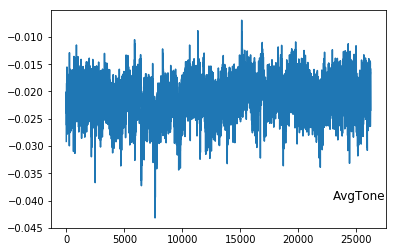

None


In [4]:
print(quickplot(df.loc['2015-02-18':'2018'][['AvgTone']]))

In [30]:
df2 = pd.merge(left=goldHourly,right=df, left_index=True, right_index=True)
#df2 = pd.merge(left=df2,right=vix, left_index=True, right_index=True, how='outer')
future_days = 7
df2['future_close'] = df2['Close'].shift(-24*(future_days))
df2['future_close'] = (df2['future_close'] - df2['Close'])/df2['Close']*100
print(df2['future_close'].head(3))

start_vals = df2.iloc[0]
def scale(df, cols):
    returnDf = pd.DataFrame({})
    for col in cols:
        shifted = df[col].shift(1)
        returnDf[col] = (shifted - df[col])/shifted*100
    return returnDf   

def unscale(df, cols, restore_first_row):
    returnDf = pd.DataFrame({}).append(df) 
    for col in cols:
        returnDf[col].iloc[0] = restore_first_row[col]
        arr = np.array(returnDf[col])
        for i in tqdm(range(1, len(arr))):
            prev = arr[i-1]
            arr[i] = prev  - arr[i]*prev/100
        returnDf[col] = arr
    return returnDf

cols_to_scale = ['Open', 'Close']#, 'VIX Close']
df2 = pd.merge(left=df2.drop(cols_to_scale, 1), right=scale(df2, cols_to_scale), left_index=True, right_index=True)
#df2 = unscale(df2, ['Close', 'Open'], start_vals)

'''print(start_vals)
print(df2['VIX Close'].head(5))
quickplot(df2[['VIX Close']])
sd, mean = numpy.std(df2['VIX Close'], axis=0), numpy.mean(df2['VIX Close'], axis=0)
df2['VIX Close'] = [x if (abs(x) < mean + 20 * sd) else x/10 for x in df2['VIX Close']]
quickplot(df2[['VIX Close']])'''

2014-01-01 00:00:00    1.984415
2014-01-01 01:00:00    2.090687
2014-01-01 02:00:00    1.910580
Name: future_close, dtype: float64


"print(start_vals)\nprint(df2['VIX Close'].head(5))\nquickplot(df2[['VIX Close']])\nsd, mean = numpy.std(df2['VIX Close'], axis=0), numpy.mean(df2['VIX Close'], axis=0)\ndf2['VIX Close'] = [x if (abs(x) < mean + 20 * sd) else x/10 for x in df2['VIX Close']]\nquickplot(df2[['VIX Close']])"

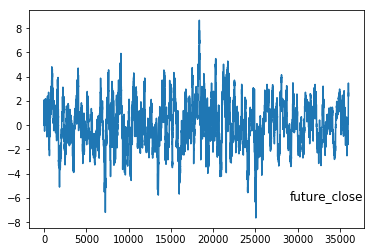

In [31]:
quickplot(df2[['future_close']])

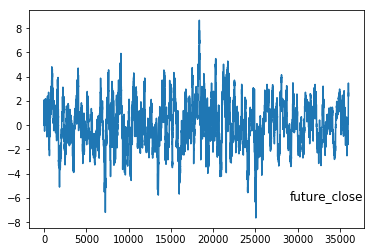

In [32]:
#df2['future_close'] = df2['future_close'].apply(lambda x :math.tanh(x))#.apply(lambda x: -0.1 if x <= -1 else (0 if (x > -1) & (x < 1) else 0.1))
quickplot(df2[['future_close']])

In [33]:
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(df, n_in=1, n_out=1, dropnan=False):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = df.shape[1]
    col_names = df.columns.values
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{var}__t-%d' % (i)).format(var=col_names[j]) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{var}__t'.format(var=col_names[j])) for j in range(n_vars)]
        else:
            names += [('{var}__t+%d'.format(var=col_names[j])) % (i) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [34]:
time_steps_back = 168*3

df2['Volume'] = df2['Volume'].fillna(1).apply(lambda v: (0 if v < 1 else math.log(v))/10)

week_dict = {0: 0, 1: 0.2, 2: 0.4, 3: 0.6, 4: 0.4, 5: 0.2, 6: 0}

df2['FromMonday'] = df2.index.map(lambda w: w.weekday()/10)
df2['Weekday'] = df2['FromMonday'].apply(lambda w: week_dict[w*10])

base_features = list(df2.columns.values)
base_features.remove('future_close')

df2 = pd.merge(left=df2,right= series_to_supervised(df2.drop('future_close', 1), n_in=time_steps_back, n_out=1), left_index=True, right_index=True)

df2.columns

Index(['Volume', 'GoldsteinScale', 'AvgTone', 'QuadClass_1', 'QuadClass_2',
       'QuadClass_3', 'RootEvent_TF_1', 'future_close', 'Open', 'Close',
       ...
       'GoldsteinScale__t', 'AvgTone__t', 'QuadClass_1__t', 'QuadClass_2__t',
       'QuadClass_3__t', 'RootEvent_TF_1__t', 'Open__t', 'Close__t',
       'FromMonday__t', 'Weekday__t'],
      dtype='object', length=5567)

In [35]:
df2.reset_index().drop('index', 1).head(5)

,Volume,GoldsteinScale,AvgTone,QuadClass_1,QuadClass_2,QuadClass_3,RootEvent_TF_1,future_close,Open,Close,...,GoldsteinScale__t,AvgTone__t,QuadClass_1__t,QuadClass_2__t,QuadClass_3__t,RootEvent_TF_1__t,Open__t,Close__t,FromMonday__t,Weekday__t
0,0.0,0.042294,0.025808,0.608312,0.115838,0.108639,0.658704,1.984415,NaN,NaN,...,0.042294,0.025808,0.608312,0.115838,0.108639,0.658704,NaN,NaN,0.2,0.4
1,0.0,0.064748,0.024903,0.666558,0.068063,0.120746,0.640707,2.090687,0.0,0.0,...,0.064748,0.024903,0.666558,0.068063,0.120746,0.640707,0.0,0.0,0.2,0.4
2,0.0,0.082678,0.024925,0.657283,0.075614,0.121768,0.662520,1.910580,0.0,0.0,...,0.082678,0.024925,0.657283,0.075614,0.121768,0.662520,0.0,0.0,0.2,0.4
3,0.0,0.015036,0.026813,0.587369,0.121728,0.091950,0.665249,1.936215,0.0,0.0,...,0.015036,0.026813,0.587369,0.121728,0.091950,0.665249,0.0,0.0,0.2,0.4
4,0.0,0.127323,0.025942,0.636780,0.145288,0.115838,0.635471,1.756523,0.0,0.0,...,0.127323,0.025942,0.636780,0.145288,0.115838,0.635471,0.0,0.0,0.2,0.4


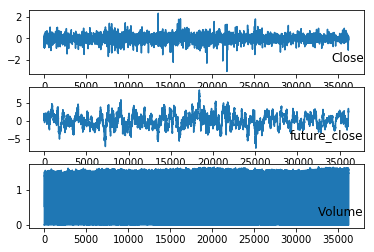

None


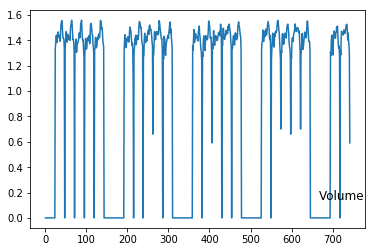

None


In [36]:
print(quickplot(df2[['Close','future_close', 'Volume']]))
print(quickplot(df2['2015-03'][['Volume']]))

In [37]:
pretrainDf = df2
start_date = datetime.datetime.strptime('2015-02-17', "%Y-%m-%d")
end_date = '2017-06-01'
val_end_date = '2018-01-01'
prediction_columns = ['future_close']
print(prediction_columns)

train_y_df = pretrainDf.loc[start_date:end_date][prediction_columns]
val_y_df = pretrainDf.loc[end_date:val_end_date][prediction_columns]
test_y_df = pretrainDf.loc[val_end_date:][prediction_columns]
val_y_df.tail(5)

['future_close']


,future_close
2018-01-01 19:00:00,1.249787
2018-01-01 20:00:00,1.261072
2018-01-01 21:00:00,1.335691
2018-01-01 22:00:00,1.351812
2018-01-01 23:00:00,1.351812


### Train and test

In [38]:
%%capture
train = pretrainDf.loc[start_date:end_date]
val = pretrainDf.loc[end_date:val_end_date]
test = pretrainDf.loc[val_end_date:]

def convertX(df):
    panel ={}
    for i in range(1, time_steps_back+1):
        r = '__t-{i}($|\D)'.format(i=i)

        df_temp = df.filter(regex=r)
        df_temp.columns = df.filter(regex=r).columns.map(lambda c: c[:len(c) - (len(str(i)) + 4)])

        colName = 'a' + str(i) if i<10 else 'b' + str(i) if i<100 else 'c' + str(i)
        panel[colName] = df_temp

    panel = pd.Panel(panel).swapaxes(0, 1, copy=True).swapaxes(1, 2, copy=True)
    print(panel)    
    return panel.values

train_X, val_X, test_X = convertX(train), convertX(val), convertX(test)
train_y, val_y, test_y = train_y_df.values, val_y_df, test_y_df.values

In [39]:
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
test_y
train_X.dtype

(20091, 11, 504) (20091, 1)
(5175, 11, 504) (5175, 1)


dtype('float64')

In [40]:
print(base_features)
opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model = Sequential()
model.add(LSTM(len(base_features)*10, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(100, return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(100, return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(100))
model.add(Dense(len(prediction_columns), activation='linear'))
model.compile(loss='mse', optimizer=opt, metrics=['mse', 'acc'])

['Volume', 'GoldsteinScale', 'AvgTone', 'QuadClass_1', 'QuadClass_2', 'QuadClass_3', 'RootEvent_TF_1', 'Open', 'Close', 'FromMonday', 'Weekday']


In [41]:
# Plotting callback used from Kavanaugh Latiolais's code, https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
        
        clear_output(wait=True)
        
        #ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot_losses = PlotLearning()

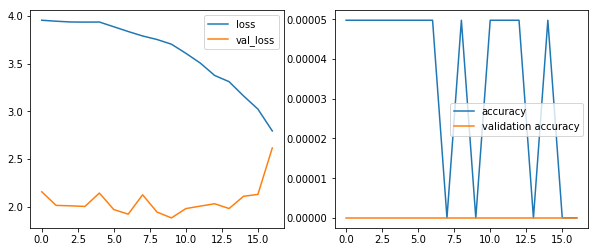

20091/20091 [==============================] - 21s 1ms/step - loss: 2.7943 - mean_squared_error: 2.7943 - acc: 0.0000e+00 - val_loss: 2.6161 - val_mean_squared_error: 2.6161 - val_acc: 0.0000e+00


In [42]:
checkpoint = ModelCheckpoint("weights-7.hdf5", monitor='val_loss', verbose=3, save_best_only=False, mode='min')
stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=3, mode='auto')

callbacks_list = [checkpoint, plot_losses]#, stopping]  

history = model.fit(train_X, train_y, epochs=17, batch_size=500, validation_data=(val_X, val_y), verbose=1, shuffle=True, callbacks = callbacks_list)

In [89]:
model.load_weights("weights-6.hdf5")

In [18]:
def invest_path_sim(deltas, wallet, prices, c_sell_func = (lambda x: 1), g_sell_func = (lambda x: 1), reinvest=True, convert_gold = True):
    wallet_hist = [wallet]
    trans_fee = 0
    start_date = predicted_weekly_deltas[0][0]
    end_date = predicted_weekly_deltas[-1][1]
    wallet_hist_cash = []
    
    def buyorsell(delta, wallet, wallet_hist_cash):
        ex_rate = prices.loc[delta[0]]
        stored = wallet[:]
        if (delta[2] > 0) & (stored[0] > 0): #BUY, only if we have cash
            cost = stored[0]*c_sell_func(delta[2]) if reinvest else min(stored[0]*c_sell_func(delta[2]), wallet_hist[0][0])
            wallet = (stored[0] - cost - trans_fee, stored[1] + cost/ex_rate)
            wallet_hist_cash = wallet_hist_cash.append((delta[0], wallet[0], wallet[1]*ex_rate))
        elif (delta[2] < 0) & (stored[1] > 0): #SELL, only if we have commodity
            cost = stored[1]*g_sell_func(delta[2])
            wallet = (stored[0] + cost*ex_rate - trans_fee, stored[1] - cost)
            wallet_hist_cash = wallet_hist_cash.append((delta[0], wallet[0], wallet[1]*ex_rate))
        else:
            wallet_hist_cash = wallet_hist_cash.append((delta[0], wallet[0], wallet[1]))
        return wallet
            
    for delta in deltas:
        wallet_hist.append(buyorsell(delta, wallet_hist[-1], wallet_hist_cash))
        
    return wallet_hist_cash

In [19]:
enable_test = False
# make a prediction
scale_factor = 0.2

yhat = pd.DataFrame(model.predict(test_X)) if enable_test == True else pd.DataFrame(model.predict(val_X))
yhat.columns = prediction_columns
yhat = yhat.set_index(test.index) if enable_test == True else yhat.set_index(val.index)
yhat = yhat*scale_factor

pred_start_date = yhat.index[0]
pred_end_date = yhat.index[-1] 

In [20]:
pred_start_date, pred_end_date

(Timestamp('2017-06-01 00:00:00'), Timestamp('2018-01-01 23:00:00'))

In [21]:
pred_appended = pd.DataFrame({}).append(pretrainDf)
col = pd.concat([pred_appended['future_close'].loc[:(pred_start_date - datetime.timedelta(hours=1))], yhat['future_close']], axis=0)
pred_appended = pred_appended.loc[:pred_end_date]
pred_appended['prediction'] = col.values

In [22]:
yhat = unscale(pred_appended, ['Close'], start_vals)

100%|██████████| 35143/35143 [00:00<00:00, 1076591.33it/s]


In [23]:
yhat['pred2'] = ((yhat['prediction']/100)*yhat['Close']) + yhat['Close']

tempdf = pd.DataFrame({}).append(yhat).drop('prediction', 1).rename(columns={'pred2': 'prediction'})
yhat['prediction'][:pred_start_date] = yhat['pred2'][:pred_start_date]

In [24]:
w = 168
diff = (pred_end_date - pred_start_date)
total_steps = int(diff.days * 24 + diff.seconds // 3600)

predicted_weekly_deltas = [] #tuple3(start date, end date, difference in predicted price)   

for i in range(0, math.ceil(total_steps/w)):
    s = pred_start_date + datetime.timedelta(hours=w*i)
    e = pred_start_date + datetime.timedelta(hours=w*(i+1))
    
    yhat[s:e] = unscale(yhat[s:e], ['prediction'], tempdf.loc[s])
    
    try:
        predicted_weekly_deltas.append((s, e, (yhat['prediction'].loc[e] - yhat['prediction'].loc[s])))
    except:
        break
        
yhat['future_close'] = ((yhat['future_close']/100)*yhat['Close']) + yhat['Close']
#print(yhat[['Close', 'prediction', 'future_close']][:-168].tail(10))

wallet = (100.0, 0.0)
print(wallet)

invest_seq = invest_path_sim(predicted_weekly_deltas, wallet, yhat['future_close'],
                             (lambda x: 1/(1 + math.e**(-abs(x)/10000))),
                             (lambda x: 1),
                             True)                    

print(invest_seq[-1][1] + invest_seq[-1][2])

100%|██████████| 119/119 [00:00<00:00, 485055.56it/s]

(100.0, 0.0)
97.7601001146


In [25]:
for i in invest_seq:
    print(i)

(Timestamp('2017-06-01 00:00:00'), 100.0, 0.0)
(Timestamp('2017-06-08 00:00:00'), 49.909169359073012, 50.090830640926988)
(Timestamp('2017-06-15 00:00:00'), 99.106165899821434, 0.0)
(Timestamp('2017-06-22 00:00:00'), 99.106165899821434, 0.0)
(Timestamp('2017-06-29 00:00:00'), 49.512487054052038, 49.593678845769404)
(Timestamp('2017-07-06 00:00:00'), 98.364512277997406, 0.0)
(Timestamp('2017-07-13 00:00:00'), 98.364512277997406, 0.0)
(Timestamp('2017-07-20 00:00:00'), 98.364512277997406, 0.0)
(Timestamp('2017-07-27 00:00:00'), 49.182207307607399, 49.182304970390007)
(Timestamp('2017-08-03 00:00:00'), 24.559818333266762, 74.151244834650967)
(Timestamp('2017-08-10 00:00:00'), 99.198194458529215, 0.0)
(Timestamp('2017-08-17 00:00:00'), 49.553102690957495, 49.645091767571728)
(Timestamp('2017-08-24 00:00:00'), 99.657926289261951, 0.0)
(Timestamp('2017-08-31 00:00:00'), 99.657926289261951, 0.0)
(Timestamp('2017-09-07 00:00:00'), 99.657926289261951, 0.0)
(Timestamp('2017-09-14 00:00:00'), 49.

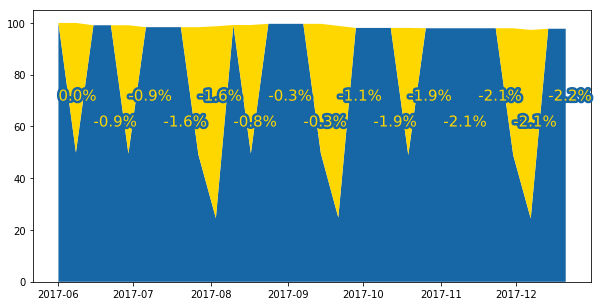

In [26]:
import matplotlib.patheffects as path_effects

fig = plt.figure(figsize=(10,5))
ind, seq1, seq2 = [c[0] for c in invest_seq], [c[1] for c in invest_seq], [c[2] for c in invest_seq]

clr1, clr2 = '#1766a6', 'gold'
p = plt.stackplot(ind, seq1, seq2, labels=['cash', 'gold'], colors=(clr1, clr2))
plt.xticks(rotation=-0)

part = 2
sum = [round((i[0] + i[1])-100, 1) for i in zip(seq1, seq2)]

for xy in zip(ind[0::part], sum[0::part], [i%2 for i in range(0, len(ind[0::part]))]): 
    text = plt.annotate('%s%%' % xy[1], xy=(xy[0], 70-xy[2]*10), textcoords='data', color=clr2, fontsize='15')
    text.set_path_effects([path_effects.Stroke(linewidth=5, foreground=clr1),path_effects.Normal()])
plt.show()

## Future Predictions

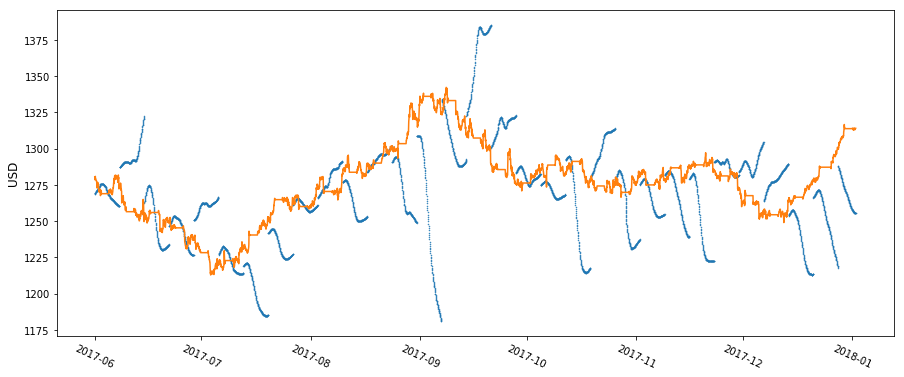

In [27]:
offset = 0
начало = pred_start_date + datetime.timedelta(weeks = 0)
конец = начало + datetime.timedelta(weeks = 50)
i = yhat.loc[начало:конец].index[:]
t = yhat[i[0]:i[-1]]['prediction']
p = yhat[i[0]:i[-1]]['future_close']
plt.figure(figsize=(15,6))
plt.xticks(rotation=-25)
plt.ylabel('USD', fontsize=12)
plt.plot(i, t + offset, linestyle='None',marker='.', markersize=1)
plt.plot(i, p)
plt.show()

In [28]:
print(pred_start_date, pred_end_date)
print(yhat['future_close'][pred_start_date], ' ' , yhat['future_close'][pred_end_date])
print(1/yhat['future_close'][pred_start_date]*yhat['future_close'][pred_end_date])

2017-06-01 00:00:00 2018-01-01 23:00:00
1280.33703866   1314.01317264
1.02630255391


In [29]:
for i in range(2):
    print('Collecting %d ...' % i)
    n = gc.collect()
    print('Unreachable objects:', n)
    print('Remaining Garbage:', )
    pprint.pprint(gc.garbage)
    print()

Unreachable objects: 2680
Remaining Garbage:
[]

Unreachable objects: 0
Remaining Garbage:
[]

